# Lecture 7

In the last lecture and in the homework, we covered how to autopopulate tables using `Imported` and `Computed` tables. 

These two table tiers require you to define a `make` function in order to populate a table using the `populate` method. However, often you know what type of data you want to go into a table, but you have not settled on a way to compute/import it. Or you want to test multiple ways of computing something and insert it into the same table. 

This is where two **feature-specfic** tables will be introducted called `AutoComputed` and `AutoImported` tables. In order to make sure everybody has the correct datajoint installed, let's execute the commands below and reconfigure datajoint:

In [1]:
import datajoint as dj
import os
# remove configuration files
global_file = os.path.expanduser(os.path.join('~', dj.settings.GLOBALCONFIG))
print(global_file)
if os.path.exists(global_file):
    print('deleting file')
    os.remove(global_file)
!pip uninstall -y datajoint
!pip install --upgrade git+https://github.com/gucky92/datajoint-python
    
# install some other packages dependencies
!pip install GitPython
!conda install -y conda
# for this tutorial also make sure you have cloudpickle installed
# although this should already be the case
!pip install cloudpickle

/Users/Josie/.datajoint_config.json
deleting file
Uninstalling datajoint-0.12.5:
  Successfully uninstalled datajoint-0.12.5
  Cloning https://github.com/gucky92/datajoint-python to /private/var/folders/p7/5ylcvg8s6zxfld6y3jyrp__r0000gp/T/pip-req-build-gh70cmtc
  Stored in directory: /private/var/folders/p7/5ylcvg8s6zxfld6y3jyrp__r0000gp/T/pip-ephem-wheel-cache-fw61kemx/wheels/15/fb/81/16f34a781d26692e477406e80137ff32e79d897c478de16d5e
Successfully built datajoint
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/Josie/opt/anaconda3/envs/henlabenv

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |           py37_0    

idna-2.9             | 49 KB     | ##################################### | 100% 
tqdm-4.46.0          | 60 KB     | ##################################### | 100% 
requests-2.23.0      | 92 KB     | ##################################### | 100% 
conda-4.8.3          | 2.8 MB    | ##################################### | 100% 
pycparser-2.20       | 92 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


**Refresh the kernel!!!** 

In [1]:
# test if datajoint imports
import datajoint as dj
# default configuration
dj.config

{   'automaker_warnings': True,
    'backup_context': None,
    'connection.charset': '',
    'connection.init_function': None,
    'database.host': 'localhost',
    'database.password': None,
    'database.port': 3306,
    'database.reconnect': True,
    'database.use_tls': None,
    'database.user': None,
    'display.limit': 12,
    'display.show_tuple_count': True,
    'display.width': 14,
    'enable_automakers': True,
    'enable_python_native_blobs': True,
    'enable_python_pickle_blobs': True,
    'fetch_format': 'array',
    'loglevel': 'INFO',
    'safemode': True,
    'tmp_folder': None}

In [2]:
# import other packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

datajoint configuration

In [3]:
dj.config['database.host'] = '127.0.0.1'
dj.config['database.port'] = 3306
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'
folder = os.getcwd()
dj.config['stores'] = {
    'localstore': {
        'protocol': 'file', # store is a normal filepath
        'location': os.path.join(folder, 'localstore') # location of store
    }
}
# connect to datajoint
dj.conn()

Connecting root@127.0.0.1:3306


DataJoint connection (connected) root@127.0.0.1:3306

# `AutoComputed` and `AutoImported` tables

`AutoComputed` and `AutoImported` tables expand the functionalities of Computed and Imported tables of datajoint. 

There are a couple reasons why these new type of table tiers were created:

* Define the general table design of autopopulated tables before having to settle on a function to autopopulate (i.e. dynamic `make` method). 
* keep track which type of function was applied using the SQL database, when autopopulating. 
* Check if function and parameters passed to function has changed before autopopulating. 
* (Keep track of package versions used when running the function before autopopulating).

The goal is to dynamically populate the table using different functions, and keep track which function and parameters were used each time when autopopulating. 

Let's use a very simple example to illustrate how the `AutoComputed` and `AutoImported` tables differ from `Computed` and `Imported` tables:

In [4]:
schema = dj.schema('lecture7')
schema.drop(True)
schema = dj.schema('lecture7')

@schema
class Data(dj.Manual):
    definition = """
    id : int auto_increment
    ---
    data : longblob
    """
    
@schema
class StatComputed(dj.Computed):
    definition = """
    -> Data
    ---
    stat : longblob
    """
    
    def make(self, key):
        data = (Data & key).fetch1('data')
        
        output = np.mean(data)
        
        key['stat'] = output
        
        self.insert1(key)
        
        print(f'inserted id: {key["id"]}')
    
@schema
class StatAutoComputed(dj.AutoComputed):
    definition = """
    -> Data
    ---
    stat : longblob
    """
    
Data.insert([
    {'data': np.random.random((100, 5))}, 
    {'data': np.random.random((150, 5))}, 
    {'data': np.random.random((100, 4))}, 
    {'data': np.random.random((100, 5))}, 
    {'data': np.random.random((200, 3))}, 
    {'data': np.random.random((10, 10))}, 
    {'data': np.random.random((1000, 2))}
])

Let's try to autopopulate

In [5]:
StatComputed.populate()

inserted id: 1
inserted id: 2
inserted id: 3
inserted id: 4
inserted id: 5
inserted id: 6
inserted id: 7


In [6]:
StatAutoComputed.populate()

TypeError: populate() missing 1 required positional argument: 'settings_name'

So that didn't work. Let's try to find out why.

Let's take a look at the ERD

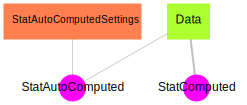

In [7]:
dj.ERD(schema)

WOW, wait a second! What is this orange table?

The orange table was generated automatically when creating the `StatAutoComputed` table, and it was made a parent table of `StatAutoComputed`. This is the "settings" table for `StatAutoComputed` that allows you to define various functions to autopopulate `StatAutoComputed`. Let's take a look at the settings table and see how we can define functions to autopopulate `StatAutoComputed` dynamically.

#### Automatically-generated settings table

You can access the settings table from the `StatAutoComputed` class:

In [8]:
print(StatAutoComputed.settings_table().definition)


        stat_auto_computed_populate_settings : varchar(63)
        ---
        description = null : varchar(4000) # any string to describe setting
        func : longblob # two-tuple of strings (module, function) or callable
        global_settings : longblob # dictionary
        entry_settings : longblob # dictionary
        fetch_method = 'fetch1' : enum('fetch', 'fetch1', 'farfetch', 'farfetch1')
        fetch_tables = null : longblob # dictionary of dict(table_name: projection)
        assign_output = null : longblob # overrides make_compatible to simply assign the output to a column
        restrictions = null : longblob # dictionary or list of restrictions
        parse_unique = null : longblob # list of unique entries for fetch
        created = CURRENT_TIMESTAMP : timestamp
        


So that's a lot to take in. Besides the primary key this table accepts various secondary attributes: some that seem required and some that don't. To get an intuition of what all of this does let's try to go back to the `make` method of the `StatComputed` table, take it apart and see what the settings table wants.

```python
def make(self, key):
    data = (Data & key).fetch1('data')
        
    output = np.mean(data)

    key['stat'] = output

    self.insert1(key)

    print(f'inserted id: {key["id"]}')
```

There are three main steps happening here:

1. fetch relevant data from a single/joined table for a specific entry
2. pass data to a function
3. insert output of function into self (table to be autopopulated)

If we take a look at the settings table there are various attributes, let's focus on the essential ones for now:

* primary_key: `stat_auto_computed_populate_settings` also called the the settings_name. This is a user-defined name to identify one particular setting.
* `description`: this is just a user-defined description to explain the function
* `func`: this is the function that is passed to the data. E.g.:
    * `np.mean`
* `global_settings`: these are keyword arguments passed to the data, as is. E.g.:
    * `{'keepdims':True}`
    * `{}`
* `entry_settings`: these are keyword arguments passed to the data mapped to specific columns. E.g.:
    * `{'a':'data'}`
* `assign_output`: What column to assign the output of the function to. E.g.:
    * in this case it would be the "stat" column

Let's try to insert settings for our `StatAutoComputed` table:

In [9]:
settings_table = StatAutoComputed.settings_table()

settings_table.insert1({
    settings_table.settings_name: 'mean', 
    'description': 'calculate the mean of data', 
    'func': np.mean, 
    'global_settings': {}, 
    'entry_settings': {'a': 'data'}, 
    'assign_output': 'stat'
})

In [10]:
StatAutoComputed.populate('mean')

Let's take a look if we populated the table

In [11]:
StatAutoComputed()

id,stat_auto_computed_populate_settings,stat
1,mean,=BLOB=
2,mean,=BLOB=
3,mean,=BLOB=
4,mean,=BLOB=
5,mean,=BLOB=
6,mean,=BLOB=
7,mean,=BLOB=


There is no real output that tells me a progress though during autopopulation!

Let's delete what we have just autopopulated:

In [12]:
StatAutoComputed.delete()

About to delete
`lecture7`.`_#stat_auto_computed`: 7 items
Proceed? [yes, No]: yes
Commited.


We can use the verbose parameter in the populate method to print what was populated

In [13]:
StatAutoComputed.populate('mean', verbose=True)

Populated entry: {'id': 1, 'stat_auto_computed_populate_settings': 'mean'}
Populated entry: {'id': 2, 'stat_auto_computed_populate_settings': 'mean'}
Populated entry: {'id': 3, 'stat_auto_computed_populate_settings': 'mean'}
Populated entry: {'id': 4, 'stat_auto_computed_populate_settings': 'mean'}
Populated entry: {'id': 5, 'stat_auto_computed_populate_settings': 'mean'}
Populated entry: {'id': 6, 'stat_auto_computed_populate_settings': 'mean'}
Populated entry: {'id': 7, 'stat_auto_computed_populate_settings': 'mean'}


So far we have done the same thing as in with the `StatComputed` table. But we can have multiple settings to autopopulate. So let's add another setting. 

In [14]:
settings_table.insert1({
    settings_table.settings_name: 'mean_axis1', 
    'description': 'calculate the mean of data', 
    'func': np.mean, 
    'global_settings': {'axis': 0}, 
    'entry_settings': {'a': 'data'}, 
    'assign_output': 'stat'
})

In [15]:
StatAutoComputed.populate('mean_axis1', verbose=True)

Populated entry: {'id': 1, 'stat_auto_computed_populate_settings': 'mean_axis1'}
Populated entry: {'id': 2, 'stat_auto_computed_populate_settings': 'mean_axis1'}
Populated entry: {'id': 3, 'stat_auto_computed_populate_settings': 'mean_axis1'}
Populated entry: {'id': 4, 'stat_auto_computed_populate_settings': 'mean_axis1'}
Populated entry: {'id': 5, 'stat_auto_computed_populate_settings': 'mean_axis1'}
Populated entry: {'id': 6, 'stat_auto_computed_populate_settings': 'mean_axis1'}
Populated entry: {'id': 7, 'stat_auto_computed_populate_settings': 'mean_axis1'}


We can also use a totally different function

In [16]:
settings_table.insert1({
    settings_table.settings_name: 'std', 
    'description': 'calculate the mean of data', 
    'func': np.std, 
    'global_settings': {}, 
    'entry_settings': {'a': 'data'}, 
    'assign_output': 'stat'
})

In [17]:
StatAutoComputed.populate('std', verbose=True)

Populated entry: {'id': 1, 'stat_auto_computed_populate_settings': 'std'}
Populated entry: {'id': 2, 'stat_auto_computed_populate_settings': 'std'}
Populated entry: {'id': 3, 'stat_auto_computed_populate_settings': 'std'}
Populated entry: {'id': 4, 'stat_auto_computed_populate_settings': 'std'}
Populated entry: {'id': 5, 'stat_auto_computed_populate_settings': 'std'}
Populated entry: {'id': 6, 'stat_auto_computed_populate_settings': 'std'}
Populated entry: {'id': 7, 'stat_auto_computed_populate_settings': 'std'}


Now let's take a look at our table:

In [18]:
StatAutoComputed()

id,stat_auto_computed_populate_settings,stat
1,mean,=BLOB=
2,mean,=BLOB=
3,mean,=BLOB=
4,mean,=BLOB=
5,mean,=BLOB=
6,mean,=BLOB=
7,mean,=BLOB=
1,mean_axis1,=BLOB=
2,mean_axis1,=BLOB=
3,mean_axis1,=BLOB=


Let's make our example a little more complicated.

In [19]:
schema = dj.schema('lecture7')
schema.drop(True)
schema = dj.schema('lecture7')

@schema
class Data(dj.Manual):
    definition = """
    id : int auto_increment
    ---
    data : longblob
    """
    
@schema
class Weights(dj.Computed):
    definition = """
    -> Data
    ---
    weights : longblob
    """
    
    def make(self, key):
        data = (Data & key).fetch1('data')
        weights = np.random.random(data.shape)
        key['weights'] = weights
        self.insert1(key)
    
@schema
class StatComputed(dj.Computed):
    definition = """
    -> Weights
    ---
    stat : longblob
    """
    
    def make(self, key):
        # join then fetch
        data, weights = ((Data * Weights) & key).fetch1('data', 'weights')
        
        output = np.mean(data * weights)
        
        key['stat'] = output
        
        self.insert1(key)
        
        print(f'inserted id: {key["id"]}')
    
@schema
class StatAutoComputed(dj.AutoComputed):
    definition = """
    -> Weights
    ---
    stat : longblob
    """
    
Data.insert([
    {'data': np.random.random((100, 5))}, 
    {'data': np.random.random((150, 5))}, 
    {'data': np.random.random((100, 4))}, 
    {'data': np.random.random((100, 5))}, 
    {'data': np.random.random((200, 3))}, 
    {'data': np.random.random((10, 10))}, 
    {'data': np.random.random((1000, 2))}
])
Weights.populate()

In [20]:
StatComputed.populate()

inserted id: 1
inserted id: 2
inserted id: 3
inserted id: 4
inserted id: 5
inserted id: 6
inserted id: 7


Now we have a problem. We want to join our data and fetch two different types of data (`data` and `weights`), multiply these data and then take the mean. 

How do we set this up in the settingtable?

In [21]:
print(StatAutoComputed.settings_table().definition)


        stat_auto_computed_populate_settings : varchar(63)
        ---
        description = null : varchar(4000) # any string to describe setting
        func : longblob # two-tuple of strings (module, function) or callable
        global_settings : longblob # dictionary
        entry_settings : longblob # dictionary
        fetch_method = 'fetch1' : enum('fetch', 'fetch1', 'farfetch', 'farfetch1')
        fetch_tables = null : longblob # dictionary of dict(table_name: projection)
        assign_output = null : longblob # overrides make_compatible to simply assign the output to a column
        restrictions = null : longblob # dictionary or list of restrictions
        parse_unique = null : longblob # list of unique entries for fetch
        created = CURRENT_TIMESTAMP : timestamp
        


* `fetch_tables`: Allows you to define multiple tables to fetch data from
    * `fetch_tables` wants you to pass a dictionary where the keys are tables or table names and the values are the columns to project
    * when this is not given then it will only fetch data from tables directly upstream!

Let's also define a function that multiplies the weights and data and then calculates the mean

In [22]:
def weighted_mean(a, weights, axis=None):
    return np.mean(a*weights, axis=axis)

Let's try to insert this function with the fetch_tables argument:

In [23]:
settings_table = StatAutoComputed.settings_table()

settings_table.insert1({
    settings_table.settings_name: 'mean', 
    'description': 'calculate the mean of data', 
    'func': weighted_mean, 
    'global_settings': {}, 
    'entry_settings': {'a': 'data'}, 
    'assign_output': 'stat', 
    'fetch_tables': {
        Data: ['data'], 
        Weights: ['weights']
    }
})

DataJointError: module <module '__main__'> does not have an associated file

So this didn't work. This is because your function is defined within your jupyter notebook rather than a python file. The settings table wants your functions defined separately from the notebook session you are working in. 

In [24]:
from functions import weighted_mean

In [25]:
settings_table.insert1({
    settings_table.settings_name: 'mean', 
    'description': 'calculate the mean of data', 
    'func': weighted_mean, 
    'global_settings': {}, 
    'entry_settings': {'a': 'data', 'weights':'weights'}, 
    'assign_output': 'stat', 
    'fetch_tables': {
        Data: ['data'], 
        Weights: ['weights']
    }
})

/Users/Josie/opt/anaconda3/envs/henlabenv/lib/python3.7/site-packages/datajoint/settings_table.py:956: UserWarning: You have uncommited changes. Consider committing before running populate.
  'You have uncommited changes. '


This warning popped up because the settings table can check if you have defined this function within a git repository you are using, and thus will track any changes to the repository (in this case its the course repository). Similarly for functions that you imported from packages (such as `np.mean`), the settings table will check the version of this package, before inserting the setting into the database. This is a somewhat more advanced feature that will allow you to track the environment in which you inserted a particular function. For now, you can ignore this warning. 

You can turn off these warning by setting a dj.config variable to False:

In [26]:
dj.config['automaker_warnings'] = False

A safer way to insert a function given a file that should run independently of its working directory is to insert the whole file with the function as such:

In [27]:
settings_table.insert1({
    settings_table.settings_name: 'mean_save', 
    'description': 'calculate the mean of data', 
    'func': ('functions.py', 'weighted_mean'), 
    'global_settings': {}, 
    'entry_settings': {'a': 'data', 'weights':'weights'}, 
    'assign_output': 'stat', 
    'fetch_tables': {
        Data: ['data'], 
        Weights: ['weights']
    }
})

This will allow you to use the function even if your working directory does not contain the `functions.py` file. 

In [28]:
StatAutoComputed.populate('mean_save', verbose=True)

Populated entry: {'id': 1, 'stat_auto_computed_populate_settings': 'mean_save'}
Populated entry: {'id': 2, 'stat_auto_computed_populate_settings': 'mean_save'}
Populated entry: {'id': 3, 'stat_auto_computed_populate_settings': 'mean_save'}
Populated entry: {'id': 4, 'stat_auto_computed_populate_settings': 'mean_save'}
Populated entry: {'id': 5, 'stat_auto_computed_populate_settings': 'mean_save'}
Populated entry: {'id': 6, 'stat_auto_computed_populate_settings': 'mean_save'}
Populated entry: {'id': 7, 'stat_auto_computed_populate_settings': 'mean_save'}


Similarly to the previous examples, we can define multiple functions to autopopulate the `StatAutoComputed` table.

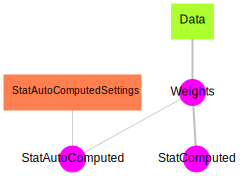

In [29]:
dj.ERD(schema)

Why I use `AutoComputed/Imported` tables over `Computed/Imported` tables:

* avoid a large chunck of code in the `make` method
* separate my table definitions from my autopopulation functions
* For calcium imaging data, it can be useful to run different algorithms to preprocess data. Having these as separate scripts makes it easier to handle and having them defined separately in the settings table keeps my workflow organized. I generally have all my analysis scripts in a separate git repository that I can import as one. 
* Sometimes I only want to change a couple `global_settings` and see how those change my result. In this case I can `fetch1` an old setting and insert it back into the settings table with `global_settings` changed. This makes it easy to modify existing functions, and keep track of different parameterizations.

For the Homework we will rework part2 of the last homework for `AutoComputed` tables.